In [1]:
import pandas as pd
import numpy as np
import os 
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import pytorch_lightning as pl
from torch import nn
import torch.nn.functional as F
import torch
import math
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from torch.utils.data import TensorDataset, DataLoader
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))
    
def RMSLE(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [3]:
class BatteryVoltageDataModule(pl.LightningDataModule):
    '''
    
    '''
    
    def __init__(self, X, y=None, batch_size=256, num_workers=0):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.X = X
        self.y = y
        self.X_scaled = None
        self.y_scaled = None
        self.X_train_scaled = None
        self.X_val_scaled = None
        self.y_train_scaled = None
        self.y_val_scaled = None
        self.X_test_scaled = None
        self.y_test_scaled = None
        
    def prepare_data(self):
        pass
    
    def setup(self, stage=None):
        
        """
        Implement the test/train stage
        """
        
        X_scaler = StandardScaler()
        y_scaler = MinMaxScaler()
        
        
        if stage == 'fit' or stage == None:
            
            self.X_scaled = X_scaler.fit_transform(self.X)
            self.y_scaled = y_scaler.fit_transform(self.y)

            self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_scaled, 
                                                                                  self.y_scaled, 
                                                                                  train_size=0.85)

            self.X_train_scaled = self.X_train
            self.X_val_scaled = self.X_val

            self.y_train_scaled = self.y_train
            self.y_val_scaled = self.y_val
            
        elif stage == 'test':
            print("stage test")
            self.X_test_scaled = X_scaler.fit_transform(self.X)
        
        else :
            print("Error: stage not defined")
        

        
    def train_dataloader(self):
        dataset = TensorDataset(torch.FloatTensor(self.X_train_scaled), 
                                torch.FloatTensor(self.y_train_scaled))
        train_loader = DataLoader(dataset, batch_size=self.batch_size, num_workers=4, shuffle=True)
        return train_loader
    
    def val_dataloader(self):
        val_dataset = TensorDataset(torch.FloatTensor(self.X_val_scaled), 
                                    torch.FloatTensor(self.y_val_scaled))
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, num_workers=4, shuffle=False)
        return val_loader
    
    def test_dataloader(self):
        test_dataset = TensorDataset(torch.FloatTensor(self.X_test_scaled), 
                                    torch.FloatTensor(self.y_test_scaled))
        test_dataloader = DataLoader(test_dataset, batch_size=self.batch_size, num_workers=4, shuffle=False)
        return test_dataloader
    
    def predict_dataloader(self):
        test_dataset = TensorDataset(torch.FloatTensor(self.X_test_scaled))
        test_dataloader = DataLoader(test_dataset, batch_size=self.batch_size, num_workers=4, shuffle=False)
        return test_dataloader
    

In [4]:
class MLP(pl.LightningModule):
  
    def __init__(self, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
        
        self.layers = nn.Sequential(
            nn.Linear(4, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid())

    
        self.learning_rate = learning_rate
        self.loss = RMSLELoss()
      

    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.layers(x)
        loss = self.loss(y_hat, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.layers(x)
        y_true = y.cpu().numpy()
        y_pred = y_hat.cpu().numpy()
        loss = RMSLE(y_true, y_pred)
        return loss
    
    def validation_epoch_end(self, val_step_outputs):
        loss = sum(val_step_outputs) / len(val_step_outputs)
        self.log('val_loss', loss)
        

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.layers(x)
        loss = self.loss(y_hat, y)
        result = pl.EvalResult()
        self.log('test_loss', loss)
        return loss
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self.model(x)
        return y_hat
    
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.75, patience=6, verbose = 1,
                                                               mode = 'min', cooldown = 0, min_lr = 10e-7)
        optimizer_dict = {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
        return optimizer_dict


In [5]:
src = os.path.join(os.path.abspath(os.getcwd()), "dataset_battery_voltage/subset_test.csv")
all_data = pd.read_csv(src)

X_input = [ 'courant_rc1', 'soc_rc1', 'temperature_rc1', 'voltage_rc1']
y_output = ['voltage_rc2']

X = all_data[ X_input ]
y = all_data[ y_output ]

In [ ]:
early_stop_callback = EarlyStopping(monitor='val_loss',
                                    min_delta=0.00,
                                    patience=20,
                                    verbose=True,
                                    mode='min')

ckpt_callback = ModelCheckpoint(mode="min", 
                                monitor="val_loss", 
                                dirpath='./temp/', filename=f'fold_test')

dataModule = BatteryVoltageDataModule(X,y, batch_size=4096)
model = MLP()
trainer = pl.Trainer(gpus=1, auto_lr_find=True, callbacks=[early_stop_callback, ckpt_callback])
trainer.tune(model, dataModule)
trainer.fit(model, dataModule)


In [14]:
simnulation_number = 34

src = os.path.join(os.path.abspath(os.getcwd()), f"dataset_battery_voltage/subset_test_sim{simnulation_number-1}.csv")
data_test = pd.read_csv(src)

X_pred = data_test[ X_input ]
y_pred = data_test[ y_output ]

X_scaler = StandardScaler()
y_scaler = MinMaxScaler()

X_pred = X_scaler.fit_transform(X_pred)
y_pred = y_scaler.fit_transform(y_pred)


model = MLP.load_from_checkpoint(str(list(Path('./temp/').glob(f'fold_test.ckpt'))[0]))
model.eval()

prediction = list()
predict_dataset = TensorDataset(torch.FloatTensor(X_pred))
predict_dataloader = DataLoader(predict_dataset, batch_size=512, num_workers=4, shuffle=False)
with torch.no_grad():
    for x, in predict_dataloader:
        prediction.append(model(x.to(model.device)).detach().cpu().numpy())
    prediction = y_scaler.inverse_transform(np.concatenate(prediction))

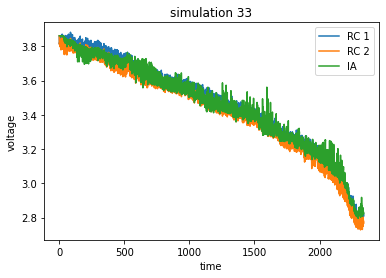

In [15]:
plt.plot(data_test["time_rc1"], data_test["voltage_rc1"])
plt.plot(data_test["time_rc1"], data_test["voltage_rc2"])
plt.plot(data_test["time_rc1"], prediction)
plt.ylabel('voltage')
plt.xlabel('time')
plt.legend(['RC 1', 'RC 2', 'IA'])
plt.title(f'simulation {simnulation_number-1}')
plt.show()

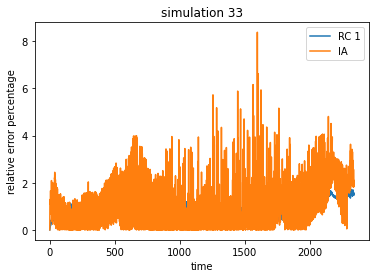

In [16]:
plt.plot(data_test["time_rc1"], 
        (data_test["voltage_rc1"] - data_test["voltage_rc2"]).abs() / data_test["voltage_rc2"] * 100)

plt.plot(data_test["time_rc1"], 
         (pd.DataFrame(prediction)[0] - data_test["voltage_rc2"]).abs() / data_test["voltage_rc2"] * 100)
plt.ylabel('relative error percentage')
plt.xlabel('time')
plt.legend(['RC 1', 'IA'])
plt.title(f'simulation {simnulation_number-1}')
plt.show()

In [ ]:
for i, pred in enumerate(preds):
    if i == 0:
        y_test = pred
    else:
        y_test = y_test + pred
y_test = y_test / len(preds)

In [ ]:
y_test

In [ ]:
def test_dataloader(X_test_scaled):
    test_dataset = TensorDataset(torch.FloatTensor(X_test_scaled))
    test_dataloader = DataLoader(test_dataset, batch_size=512, num_workers=4, shuffle=False)
    return test_dataloader

In [ ]:
model = MLP(X, y, X_test, 1e-3, y_scaler=y_scaler, seed=42)
model = model.load_from_checkpoint(str(list(Path('./temp/').glob(f'fold_{10}_{1}*ckpt'))[0]))
model.eval()

In [ ]:
simnulation_number = 147

src = os.path.join(os.path.abspath(os.getcwd()), f"dataset_battery_power/subset_test_sim{simnulation_number-1}.csv")
all_data = pd.read_csv(src)

X_sim23 = [ 'courant_rc1', 'soc_rc1', 'temperature_rc1', 'voltage_rc1']
y_sim23 = ['voltage_rc2']

X_test = all_data[ X_input ]
y_test = all_data[ y_output ]

X_scaler = StandardScaler()
y_scaler = MinMaxScaler()

X = X_scaler.fit_transform(X_train)
y = y_scaler.fit_transform(y_train)
X_test = X_scaler.transform(X_test)

In [ ]:
y_test = list()
test_loader = test_dataloader(X_test)
for x, in test_loader:
    y_test.append(model(x.to(model.device)).detach().cpu().numpy())
y_test = y_scaler.inverse_transform(np.concatenate(y_test))

In [ ]:
print(((all_data["voltage_rc1"] - all_data["voltage_rc2"]).abs() / all_data["voltage_rc2"] * 100).mean())
print(((pd.DataFrame(y_test)[0] - all_data["voltage_rc2"]).abs() / all_data["voltage_rc2"] * 100).mean())


In [ ]:
print(((all_data["voltage_rc1"] - all_data["voltage_rc2"]).abs() / all_data["voltage_rc2"] * 100).std())
print(((pd.DataFrame(y_test)[0] - all_data["voltage_rc2"]).abs() / all_data["voltage_rc2"] * 100).std())